

# Main 코드

* 20211206 : 일부 데이터 추가 후 파라미터 재조정, 로직추가, time step 도입
* 20211208 : 파라미터 최적화, 일부로직 수정
* 20211209 : 발표용 최종세팅(0.9.0)
* 20211213 : 설비비가동시 데이터 수집 중단 추가, 일부 파라미터 변경, 입력데이터 정규화 추가(time step 제거)\



## comment
### 2021-12-17
* 다른 정상적인 실린더들(많은 양)에 대해 검증해볼것
* 계산 주기를 결정할것. (편차알고리즘은 이전 구간에서 계산된 편차를 활용하는 방법으로 계산 주기를 낮출수잇을것같다는 의견있으심)


$$ a


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings


from collections import deque
from matplotlib import font_manager, rc


font_path = "C:\Windows\Fonts\LG_Smart_UI-Light.ttf"
font = font_manager.FontProperties(fname = font_path).get_name()
rc('font', family = font)
warnings.filterwarnings(action='ignore')
# ## input에 대한 실린더 고장 클래스
# ## input_data(csv) 가 모여있는 디렉토리 입력.


## 실린더 정보 저장용
class CYLINDER():
    def __init__(self, is_abnormal = None, value_data = None, max_limit = None, min_limit = None, count = None):
        self.stat = is_abnormal     # 이상유무 1 = 이상, 0 = 정상 , [1, 0, 1, 0, 1] --> 0, 2, 4 번째 실린더 이상
        self.value = value_data     # 각 실린더마다 데이터
        self.max_limit = max_limit  # 각 실린더마다 상한선 변동값
        self.min_limit = min_limit  # 각 실린더마다 하한성 변동값
        self.count = count          # 넘어간 횟수

    # 요약정보 가져오기 위해
    def get(self, index):
        return [self.stat[index], self.value, self.max_limit, self.min_limit, self.count]


## 전체 동작 flow
class CYL_DETECTOR():


    ## 초기세팅, 데이터 입력 부분

    def __init__(self, file_path, UPDATE_TIME = 10, SIGMA = 3, WEIGHT = 0.1, LIMIT = 1000, STEP = 5):

        self.csv_path = file_path
        self._UPDATE_TIME_SET = UPDATE_TIME
        self._SIGMA = SIGMA
        self._WEIGHT = WEIGHT
        self._LIMIT = LIMIT
        self._STEP = STEP
        self._NUMBER_OF_ALLOW = 50 / self._STEP
    ## 동작시키는 함수 ##
    def run(self):



        print(f' 실린더 파일 읽는 중 ... ' , end='\r', flush=True)
        self.df = self.data_preprocess()

        print(f' 실린더 파일 읽는 중 ... 완료  ', end = "\n ", flush=True)
        self.cylinder_info_std = self.cylinder_analysis_std(self.df)

        print('\r')
        self.cylinder_info_crest = self.cylinder_analysis_crest(self.df)
        self.result = []
        self.result2 = []
        ####

        # std와 crest 겹치는 인덱스 찾는 부분
        for i, x in enumerate(self.cylinder_info_std.stat):
            if x :
                self.result.append(i)

        print(f'cylinder {len(self.result)}')
        #
        for i, x in enumerate(self.cylinder_info_crest.stat):
            if x :
                self.result2.append(i)

        self.result = list(set(self.result) & set(self.result2))

        print(f'crest {len(self.result2)}')
        self.result.sort()
        return self.result
        ####


    # 전처리 필요하면 여기 ~~~~~~~~~ 분석용 함수에 맞는 input 데이터를 제공하는 함수
    def data_preprocess(self):
        original = pd.read_csv(self.csv_path, encoding='CP949') # 시간 포함
        copy_df = pd.DataFrame(np.copy(original),columns = original.columns)    # 시간 필터링
        size = len(copy_df.iloc[:,[0]])
        idx_list = []



        if size >= 1000:
            for i in range(1000):
                idx_list.append(int((size/1000) * (i)))
                # step 만큼 데이터 skip 하면서 읽음
            copy_df = copy_df.iloc[idx_list, 1:]

        else:
            # step 만큼 데이터 skip 하면서 읽음
            copy_df = copy_df.iloc[:, 1:]

        copy_df = copy_df.reset_index().iloc[:,1:]
        self.df_columns = copy_df.columns
        # print(copy_df)
        # copy_df = copy_df.fillna(0)


        del(original)
        return copy_df


    #### 한계선
    # 상 - 하한선 결정하는 함수
    def determine_limit(self, data, sigma, weight):




        std, mean = np.std(data), np.mean(data)



        std = std.round(2)
        mean = mean.round(2)

        threshold = 0.1

        if std * sigma >= threshold:
            upper_line = (mean + (std * sigma)) * (1 + weight)
            lower_line = (mean - (std * sigma)) * (1 - weight)
        else:
            upper_line = (mean + threshold) * (1 + weight)
            lower_line = (mean - threshold) * (1 - weight)

        if lower_line < 0 : lower_line = 0

        return upper_line,0, std, mean

    #### Crest Factor
    def get_crest_factor(self, data):

        return (np.max(data) - np.min(data)) / np.sqrt(np.sum(np.power(data,2))/ len(data)) ### { 차이 / 제곱근 }



    # input 실린더 데이터 --> 이상 실린더 리턴 (편차사용)
    def cylinder_analysis_std(self, cyl_dataframe):

        # 1. Input 데이터를 입력받는다.
        cyl_size = len(cyl_dataframe.columns)
        data_size = len(cyl_dataframe)


        ######## 리턴용 변수 생성 ########
        type, value, max, min, cnt = [], [], [], [], []

        self.sigma, self.weight, self.limit = self._SIGMA, self._WEIGHT, self._LIMIT


        ##############################


        print(f'datasize ========= {data_size}')


        ## 탐색 (전체 실린더)
        for cyl_i in range(cyl_size):
                        ###### 전체 변수 & 초기화 ####
            is_abnormal, count, repeat_counter = 0, 0, 0
            upper_limit, lower_limit = [], []
            upper_line, lower_line = 0, 0
            is_collected = False


            data_box, check_box, mini_box = deque(), [], []
            cylinder_data = cyl_dataframe.iloc[:, cyl_i]
            ############################

            ## 탐색 (개별 실린더)
            for idx, data in enumerate(cylinder_data):
                data_box.append(data)
                mini_box.append(data)

                # 데이터 수집안됐으면 추가하고 다음으로
                if not is_collected:
                    if len(data_box) < int(data_size/10):


                        ## 필터링 --- 1 : 매우 낮은 값이 계속 진행되는 경우 모두 초기화.
                        if len(data_box) > 2 and np.std(data_box) < 0.001:
                            data_box.clear()
                            mini_box.clear()

                        upper_limit.append(None)
                        lower_limit.append(None)

                        continue

                    # 수집했으면 std, mean 라인 스타트
                    if len(data_box) == int(data_size/ 10):

                        upper_line, lower_line, std, mean = self.determine_limit(data_box, self.sigma, self.weight)

                        is_collected = True



                ## 필터링 --- 2 : 매우 낮은값이 계속 진행되는 경우 모두 초기화.
                if len(mini_box) > 10 and np.std(mini_box) < 0.01 :

                    # std가 일정값 미만이면, 꺼져있다는 뜻이므로 초기화. 추후 계산을 위해 초기화 뒤 마지막값 하나를 넣어줌.
                    tmp = data_box.pop()
                    data_box.clear()
                    mini_box.clear()
                    data_box.append(tmp)





                ## UPDATE --- 1 : 일정주기마다
                if len(data_box) % int(data_size/self._UPDATE_TIME_SET) == 0:
                    upper_line, lower_line, std, mean = self.determine_limit(data_box, self.sigma, self.weight)







                # UPDATE --- 2 : 선을 넘는 경우
                if (data > upper_line or data < lower_line):

                    check_box.append(True)
                    count += 1

                    upper_line, lower_line, std, mean = self.determine_limit(data_box, self.sigma/2, self.weight/2)


                    # 편차가 너무 큰 경우 편차계산에서 제외
                    if std > mean * 0.01:
                        data_box.pop()

                    # 연속적으로 검출된 경우
                    if len(check_box) >= self._NUMBER_OF_ALLOW:
                        is_abnormal = 1



                else:
                    mini_box.clear()
                    check_box.clear()


                upper_limit.append(upper_line)
                lower_limit.append(lower_line)


                if(len(check_box) > self._LIMIT/2):
                    is_abnormal = 0

            # 일정부분 검출된경우 이상실린더
            if count > self._NUMBER_OF_ALLOW:
                is_abnormal = 1

            # print(f' 실린더 분석 중 : {cyl_i + 1}/{cyl_size} 완료',end ="\r", flush =True)
            print(f' 실린더 편차 분석 중 : {int(( (cyl_i+1) /cyl_size)*100)}% ( {cyl_i +1} / {cyl_size} )' , end='\r', flush=True)

            if is_abnormal:
                type.append(is_abnormal)
                value.append(cylinder_data)
                max.append(upper_limit)
                min.append(None)
                cnt.append(count)

            else:
                type.append(is_abnormal)
                value.append(cylinder_data)
                max.append(upper_limit)
                min.append(None)
                cnt.append(count)

        # cylinder 정보 저장
        cylinder = CYLINDER(is_abnormal = type, value_data = value, max_limit = max, min_limit = min, count = cnt)
        print(f' 실린더 편차 분석 완료 : {int(( (cyl_i+1) /cyl_size)*100)}% ( {cyl_i +1} / {cyl_size} )' , end='\r', flush=True)

        # 반환

        return cylinder

    ##############  알고리즘 - 2  ##############
    # input 실린더 데이터 --> 이상 실린더 리턴 (crest factor사용 )
    def cylinder_analysis_crest(self, cyl_dataframe):

        ######## 리턴용 변수 생성 ########
        type, value, max, min, cnt = [], [], [], [], []
        self.crest_factor_list = []
        ###############################

        # 1. Input 데이터를 입력받는다.
        cyl_size = len(cyl_dataframe.columns)
        data_size = len(cyl_dataframe)


        ## 탐색 (전체 실린더)
        for cyl_i in range(cyl_size):
            ###### 전체 변수 & 초기화 ####
            X, is_abnormal = [], 0

            crest_factor = 0
            is_collected = False


            data_box = deque()
            cylinder_data = cyl_dataframe.iloc[:, cyl_i]
            ############################

            ## 탐색 (개별 실린더)
            for idx, data in enumerate(cylinder_data):
                if idx  % 6 != 0:
                    continue
                # 취합되지 않았다면,



                if not is_collected:
                    if len(data_box) <   6:

                        # 데이터박스에 취합
                        data_box.append(data)

                        # 다음 데이터로
                        continue

                    # 취합됐으면
                    else:
                        # Crest Factor 계산
                        crest_factor = self.get_crest_factor(data_box)

                        # 취합 됐다고 스위치 온
                        is_collected = True




                crest_factor = self.get_crest_factor(cylinder_data[idx-5:idx])


                if 0.6 <=  crest_factor <=  4:
                    X.append(1)


                else :
                    X.append(0)





                if len(X) == 20:
                    if sum(X)/len(X) >= 0.3:

                        is_abnormal = 1
                        X=[]
                    else :
                        X=[]
                        continue
            type.append(is_abnormal)
            value.append(cylinder_data)



            print(f' 실린더 Crest Factor 분석 중 : {int(( (cyl_i+1) /cyl_size)*100)}% ( {cyl_i +1} / {cyl_size} )' , end='\r', flush=True)

        # cylinder 정보 저장
        cylinder = CYLINDER(is_abnormal = type, value_data = value)
        print(f' 실린더 Crest Factor 분석 완료 : {int(((cyl_i+1) /cyl_size)*100)}% ( {cyl_i +1} / {cyl_size} )' , end='\r', flush=True)

        # 반환
        return cylinder


    # Test 출력용.
    def print(self):
        pass

# 실행코드

In [29]:
os.getcwd()

csv_name = '20211005.csv'
detector = CYL_DETECTOR('data/PKG4/1010/'+csv_name, SIGMA=3, WEIGHT=0.1, UPDATE_TIME=20)

# detector = CYL_DETECTOR('output/gb/pkg4/1010.csv',WEIGHT= 0.1,SIGMA=3, UPDATE_TIME=10)
#
result = detector.run()
print(detector.df_columns[result])
print(f'{len(detector.df_columns[result])}개 검출 완료')



 실린더 파일 읽는 중 ... 완료  
 datasize ========= 1000
 실린더 편차 분석 완료 : 100% ( 331 / 331 )
cylinder 5 Factor 분석 완료 : 100% ( 331 / 331 )
crest 3
Index(['ASSEMBLY.TAB_WELDING.ANA.LEAD_SUPPLY1PLUSYPOSITIONING_열림_시간_PV', 'ASSEMBLY.TAB_WELDING.ANA.LEAD_SUPPLY1PLUSLEADPP2_하강_시간_PV'], dtype='object')
2개 검출 완료


    # 그림 plot 코드

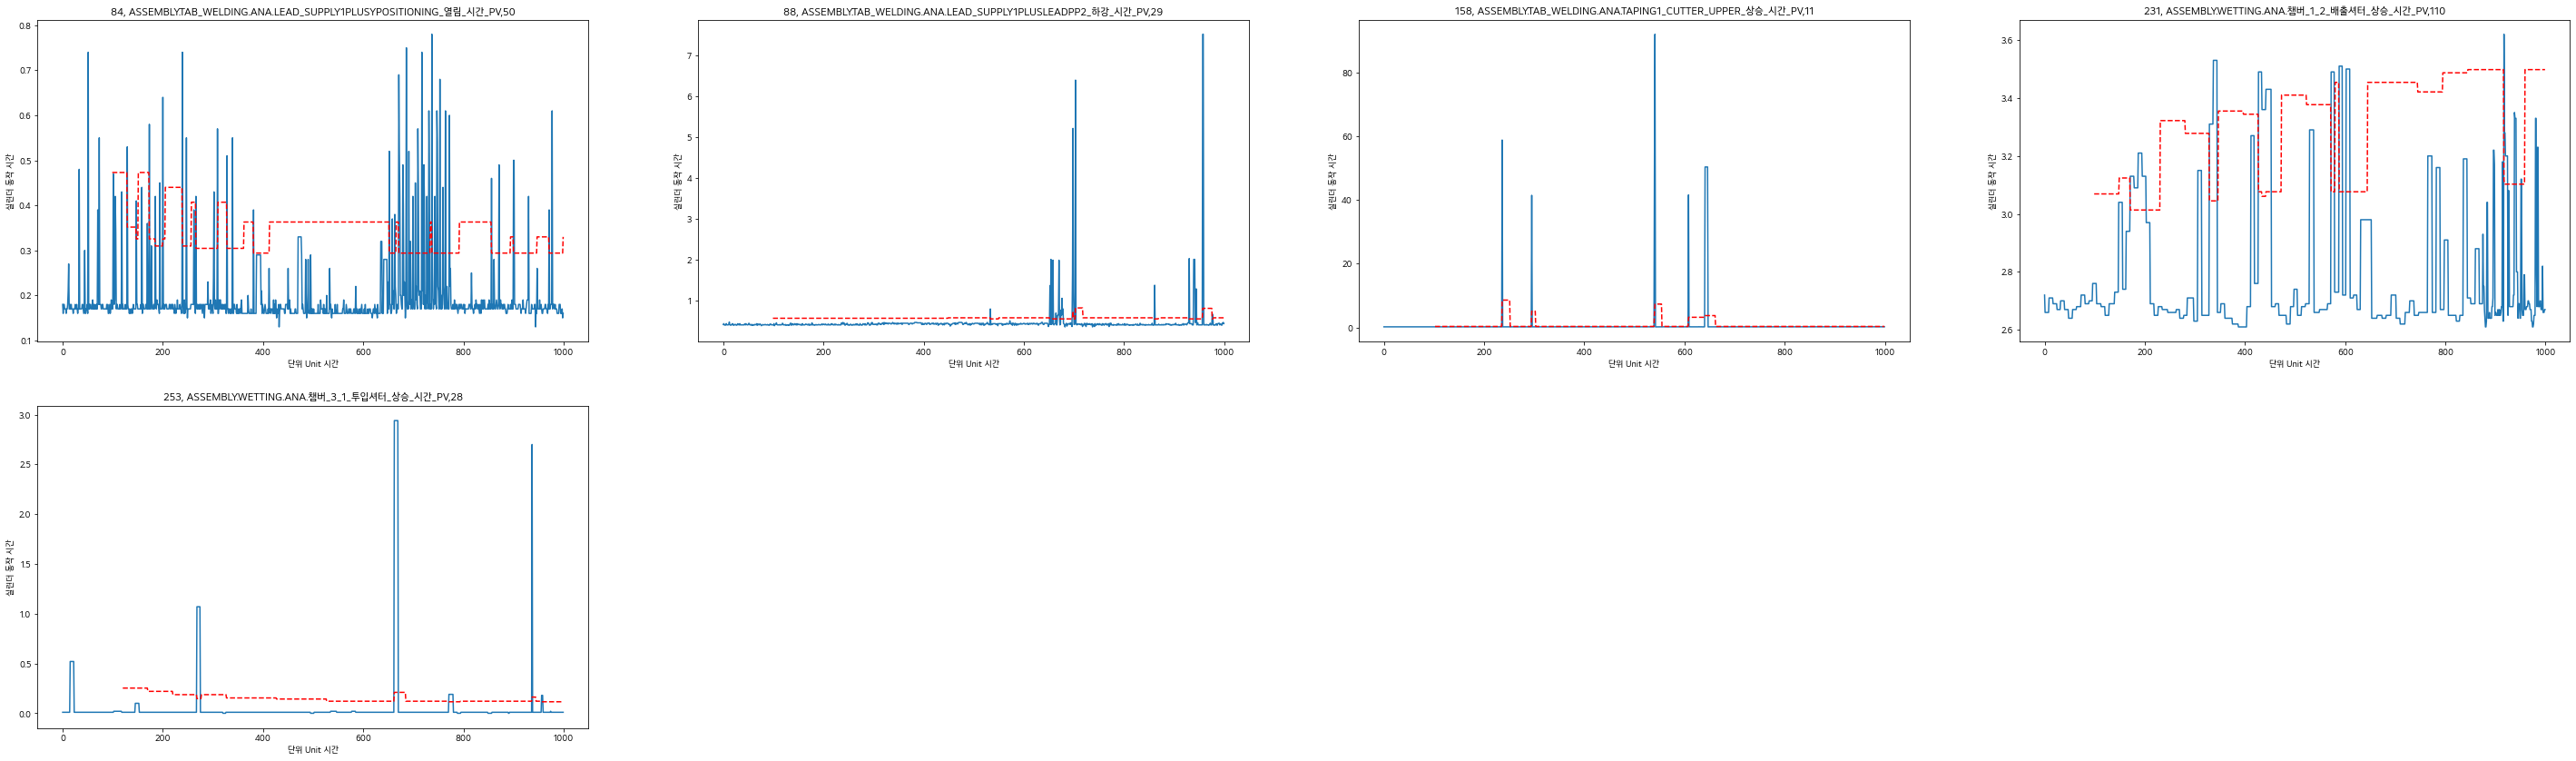

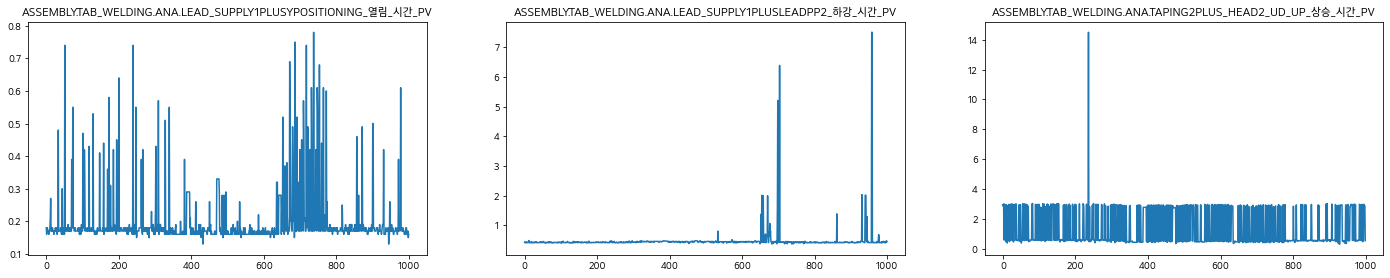

In [30]:
# detector.cylinder_info_std.value[0]

import time
# b=0
# c=0
# for i in detector.cylinder_info_std.stat:
#     c+=1
#     if i == 1 :
#
#         b+=1
#         # print(c)
# print(b)
plt.figure(figsize=(50,30))
b=0
c=0


for i in range(84,len(detector.df_columns)):


    if   detector.cylinder_info_std.stat[i]:
        b+=1
        plt.subplot(4,4,b)

        plt.title(f'{i}, {detector.df_columns[i]},{detector.cylinder_info_std.count[i]}')
        plt.xlabel('단위 Unit 시간')

        plt.ylabel('실린더 동작 시간')

        plt.plot(detector.cylinder_info_std.value[i])

        plt.plot(detector.cylinder_info_std.max_limit[i], 'r--', label = '수정중인 상한선')

        # plt.plot(detector.cylinder_info_std.min_limit[i], 'b--', label = '수정중인 하한선')

plt.figure(figsize=(50,30))

b = 0

for i in range(0,len(detector.df_columns)):

    #
    if   detector.cylinder_info_crest.stat[i]:
        b+=1
        plt.subplot(6,6,b)

        plt.title(f'{detector.df_columns[i]}')

        plt.plot(detector.cylinder_info_crest.value[i])


In [ ]:
detector.cylinder_info_std.value()


# 그림 저장 코드 + plot

1
[105]


ValueError: x, y, and format string must not be None

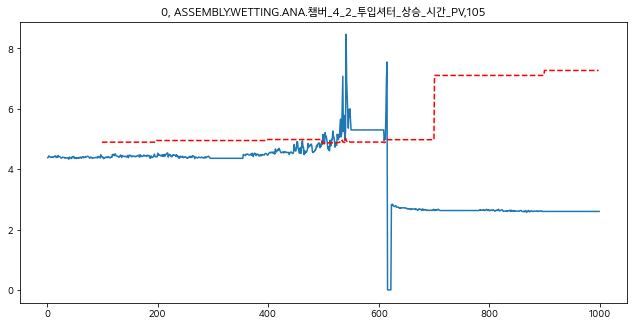

In [18]:
# detector.cylinder_info_std.value[0]

import time
b=0
c=0
for i in detector.cylinder_info_std.stat:
    c+=1
    if i == 1 :
        b+=1
        # print(c)
print(b)
plt.figure(figsize=(50,30))
b=0
c=0
print(detector.cylinder_info_std.count)

folder_name = time.strftime('%Y-%m-%d %H%M%S',time.localtime())
final_dir = f'output/cylinder/{folder_name} - {csv_name}'

if not os.path.exists(final_dir):
    os.mkdir(final_dir)

for i in range(0,len(detector.df_columns)):

    if  detector.cylinder_info_std.stat[i]:
        b+=1
        plt.subplot(5,4,b)

        plt.title(f'{i}, {detector.df_columns[i]},{detector.cylinder_info_std.count[i]}')

        file_name = final_dir+'/std_'+f'{i}, {detector.df_columns[c]},{detector.cylinder_info_std.count[i]}.jpg'

        # plt.title(f'FDC 알람내역 기존, 수정중인 알고리즘 비교')
        plt.plot(detector.cylinder_info_std.value[i])
        plt.plot(detector.cylinder_info_std.max_limit[i], 'r--', label = '수정중인 상한선')
        plt.plot(detector.cylinder_info_std.min_limit[i], 'b--', label = '수정중인 하한선')

        plt.savefig(file_name)

    c+=1
c = 0

b = 0
plt.figure(figsize=(50,30))

for i in range(0,len(detector.df_columns)):


    #
    if  detector.cylinder_info_crest.stat[i]:
        b+=1
        plt.subplot(6,6,b)

        plt.title(f'{detector.df_columns[i]}')

        file_name = final_dir+'/crest_'+ f'{i}, {detector.df_columns[i]}.jpg'
        # plt.title(f'FDC 알람내역 기존, 수정중인 알고리즘 비교')
        plt.plot(detector.cylinder_info_crest.value[i])

        plt.savefig(file_name)
#
#     c+=1


print(len(detector.cylinder_info_std.value))

In [ ]:
a = []
b = [1,3,3,43,4,5,234,523,52,34,23,45,234,52,345,23,6423,45,2,4312,12,341,234,12,341,23,521,512,34,126,35,634,34,5,34]

b = pd.DataFrame(b)
moving_avg_data = b.rolling(10).mean()
moving_std_data = b.rolling(10).std()

print(moving_std_data, moving_avg_data)